In [1]:
import os
import gc
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import sys
sys.path.append( '../util' )
import util as util
from ctgan import CTGAN
from sklearn.preprocessing import LabelEncoder
import joblib

/var/folders/1s/tyt3m2l12dz6s028_blqch7r0000gn/T/ipykernel_60478/2140316346.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def create_multiclass_classification_model(input_shape, num_classes):
    inputs = Input(shape=(input_shape,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x) 
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [3]:
ctgan_model = CTGAN.load('../generator_custom/medium_synthesizer.pkl')

In [4]:
synthetic_data = ctgan_model.sample(25000000)

In [5]:
discrete_columns = ['HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 
                    'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC']
encoders_new = joblib.load('../data_breakdown/column_encoders.joblib')
for column in discrete_columns:
    if column in encoders_new:
        synthetic_data[column] = encoders_new[column].inverse_transform(synthetic_data[column])
print(synthetic_data.dtypes)

flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float64
HTTPS              float64
DNS                float64
Telnet             float64
SMTP               float64
SSH                float64
IRC                float64
TCP                float64
UDP                float64
DHCP               float64
ARP                float64
ICMP               float64
IPv                float64
LLC                float64
Tot sum            float32
Min                float32
Max                float32
AVG                float32
S

In [14]:
import numpy as np

train_notneeded, test = util.import_dataset(7,"dnn")
del train_notneeded
y_train = synthetic_data[util.y_column]
y_test = test[util.y_column]

X_train = synthetic_data.drop(util.y_column, axis=1)
X_test = test.drop(util.y_column, axis=1)

label_encoder = LabelEncoder()
y_train_encoded = y_train.to_numpy()
y_test_encoded = label_encoder.fit_transform(y_test)
print(np.unique(y_train_encoded))
print(y_train_encoded.dtype)
print(y_test_encoded.dtype)
print(X_train.dtypes)
print(X_test.dtypes)


Importing datasets.....
Processing training and test data....
Finished processing training and test data
Mapping labels to seven classes.....
Data import and processing complete....
[0 1 2 3 4 5 6 7]
int64
int64
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float64
HTTPS              float64
DNS                float64
Telnet             float64
SMTP               float64
SSH                float64
IRC                float64
TCP                float64
UDP                float64
DHCP               float64
ARP  

In [15]:
num_classes = len(label_encoder.classes_)
print(" Number of classes is:" )
print(num_classes)
print("")
model = create_multiclass_classification_model(len(util.X_columns),num_classes)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#https://keras.io/api/models/model_training_apis/
history = model.fit(x=X_train, y=y_train_encoded,
                    validation_split=0.2, epochs=50, 
                    batch_size=256, callbacks=[early_stopping])

model.save('./dnn_model_trained_synthetic.keras')
test_loss, test_acc = model.evaluate(X_test, y_test_encoded, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')
del X_train,X_test,y_train,y_test_encoded,synthetic_data

 Number of classes is:
8

Epoch 1/50
78125/78125 ━━━━━━━━━━━━━━━━━━━━ 182s 2ms/step - accuracy: 0.8118 - loss: 0.4655 - val_accuracy: 0.8930 - val_loss: 0.3018
Epoch 2/50
78125/78125 ━━━━━━━━━━━━━━━━━━━━ 151s 2ms/step - accuracy: 0.8734 - loss: 0.3393 - val_accuracy: 0.8952 - val_loss: 0.3046
Epoch 3/50
78125/78125 ━━━━━━━━━━━━━━━━━━━━ 163s 2ms/step - accuracy: 0.8800 - loss: 0.3262 - val_accuracy: 0.8918 - val_loss: 0.3258
Epoch 4/50
78125/78125 ━━━━━━━━━━━━━━━━━━━━ 117s 1ms/step - accuracy: 0.8813 - loss: 0.3228 - val_accuracy: 0.8901 - val_loss: 0.3248
Epoch 5/50
78125/78125 ━━━━━━━━━━━━━━━━━━━━ 115s 1ms/step - accuracy: 0.8822 - loss: 0.3200 - val_accuracy: 0.8957 - val_loss: 0.2989
Epoch 6/50
78125/78125 ━━━━━━━━━━━━━━━━━━━━ 130s 2ms/step - accuracy: 0.8828 - loss: 0.3185 - val_accuracy: 0.8919 - val_loss: 0.3119
Epoch 7/50
78125/78125 ━━━━━━━━━━━━━━━━━━━━ 135s 2ms/step - accuracy: 0.8832 - loss: 0.3178 - val_accuracy: 0.8873 - val_loss: 0.3302
Epoch 8/50
78125/78125 ━━━━━━━━━━━━━

Test accuracy: 0.9761347770690918, Test loss: 0.11599690467119217


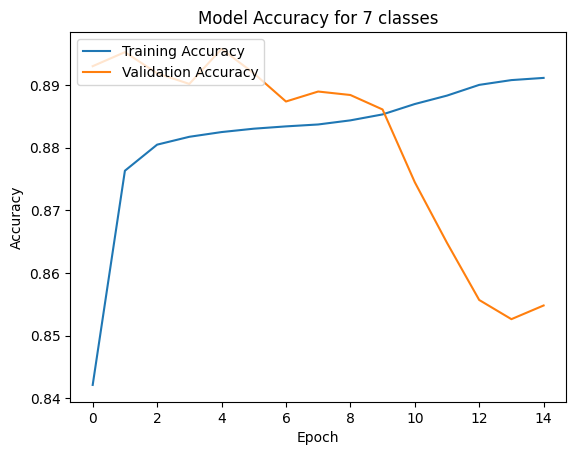

In [16]:
import matplotlib.pyplot as plt
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy for 7 classes')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [8]:
###Change this name so you don't overrwrite the one we have now
model.save('./dnn_model_trained_synthetic.keras')

In [17]:
from tensorflow.keras.models import load_model
loaded_model = load_model('./dnn_model_trained_synthetic.keras')
print(loaded_model.summary())
print(loaded_model.get_config())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 46)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,066 (90.11 KB)

 Trainable params: 7,688 (30.03 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,378 (60.07 KB)

None
{'name': 'functional_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 46), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None, 'name': 'input_layer', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 46]}, 'name': 'dense', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 46), 'dt

In [18]:
for layer in loaded_model.layers:
    weights = layer.get_weights()  
    #ValueError: not enough values to unpack (expected 2, got 0) <- fixing this error, not all llayers have bias or weight
    if len(weights) > 0:
        print(f"{layer.name} weights shape: {weights[0].shape}")
        if len(weights) > 1:
            print(f"{layer.name} biases shape: {weights[1].shape}")
    else:
        print(f"{layer.name} has no weights or biases.")

input_layer has no weights or biases.
dense weights shape: (46, 64)
dense biases shape: (64,)
dropout has no weights or biases.
dense_1 weights shape: (64, 64)
dense_1 biases shape: (64,)
dense_2 weights shape: (64, 8)
dense_2 biases shape: (8,)


In [19]:
from tensorflow.keras.utils import plot_model



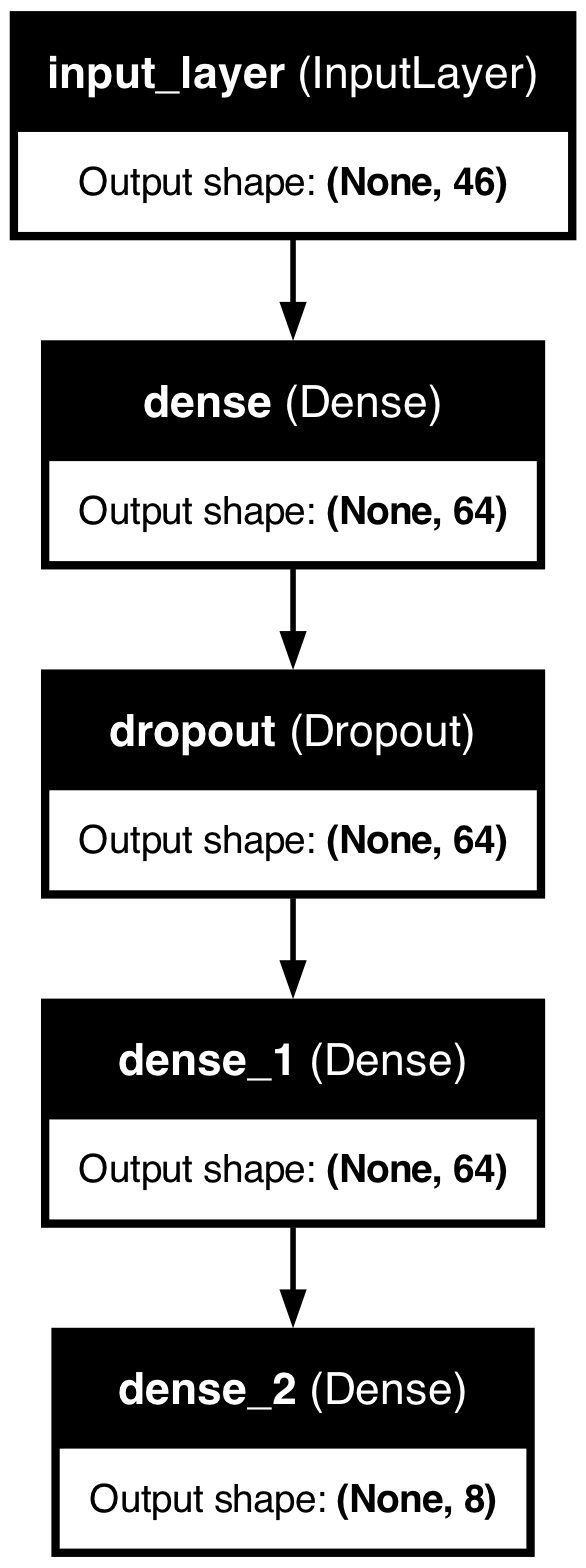

In [21]:
plot_model(loaded_model, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)